# Understand backpropogation for linear layer

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# functions to use
# linear line
def lin(X, w, b): return X@w + b
# RELU implementation
def relu(x): return x.clamp_min(0.)
# MSE error
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

#forward with loss fn
def forward(X, Y):
    Z = lin(X, w, b)
    U = relu(Z) # This is model's output prediction ypred.
    C = mse(U, Y)
    return C



In [82]:
# Defining gradient. 
# We define gradient of each function wrt it output (ie calculate derivative of input wrt output, or d(input)/d(output)
# for each delta change in output what was the delta change in input

# NOTE: Learning MSE grad actually is calculated for loss of each Ypred (U) - does pytorch save all these gradients?
# Learning: gradient of ypred is ypred.grad = -2/N*(Yact - Ypred)
# U - input
# Y - ouput
def mse_grad_loop(U, Y):
    N = len(U)
    results = [-2./N*(Y[i]-U[i]) for i in range(N)]
    return torch.FloatTensor(results)

# A faster way to implement the above 
# NOTE: this faster method gives a matrix with 1 extra dimension so there are N^2 values.
# to match values from mse_grad_loop you look at the diagonal of this torch.diagonal(mse_grad(Y,Yr))
def mse_grad(U, Y):
    # grad of loss with respect to output of previous layer
    N = U.shape[0]
    # we have to unsqueeze Y because its' dimensions is (N) while U's is (N,1)
    # not doing so would broadcast and return wrong dimensions
    U.g = -2. * (Y.unsqueeze(-1)-U) / N #Gradient saved under U.g it is used in chain rule as we calculate other gradients
    return U.g


In [ ]:
#Gradient of RELU function is simple. It has two line with slope of 0 and slope of 1
# PyTorch’s operator > 0 makes it really easy. If an element of a tensor is bigger than 0, it will be True, otherwise False.
# Calling .float() on such tensor will turn Falses and Trues exactly into 0s and 1s, which is what we need.
# 
# Z - input
# U - ouput
def relu_grad(Z, U):
    # grad of relu with respect to output of previous layer
    du_dz = (Z > 0).float()
    dC_du = U.g # gradient from previous mse_grad function
    dC_dz = dC_du * du_dz # chain rule
    Z.g = dC_dz
# Learning: as we are multiplying br 0 for <= 0 value of input Z we are basically making gradient 0 this is why learning stops in this range

In [ ]:
# Gradient of linear function
# we calculate gradient wrt weight and bias
# As [Z = X@w + b] dZ/dw will be X and gZ/gb will be 1
# so when we apply chain rule some gradients coming from RELU are 0 and some are gradients of loss function
# so the gradient of bias is same as gradient of loss which is -2/N loss
# gradient of weight is the same gradient multiplied by X. This must be the reason that when we train in our OneHiddenLayerNet 
# experiment we see lot of fluctuation for weight parameter corresponding to higher X and maybe why network trains from less value of X first

# Z - output
# w - input
# b - input
def lin_grad(X, Z, w, b):
    n = X.shape[0]
    result_per_row = []
    for i in range(n):
        result_per_row.append(Z.g[i] @ X[i].unsqueeze(0))
    # we have to unsqueeze just because of how @ is implementes for [1]@[1xN]
    stacked = torch.stack(result_per_row).unsqueeze(-1)

    w.g = stacked.sum(0) # now summed!
    b.g = Z.g.sum(0)
    

### Learning: 
Even for MSE we calculate gradient for all x & y values in the matrix and only in the end when we calculate gradient for weight and bias we do a SUM

But a point to note, we have +ve and -ve gradient being passed from loss function's gradient based on if yact - ypred is +ve or -ve
so sum may be washed, is this what we want per batch?

In [57]:
X = torch.arange(0.,10).unsqueeze(-1) # unsqueeze(-1) converts shape (10,) to shape(10,1)
w = torch.Tensor([[2.]])
b = torch.Tensor([-4.])

In [58]:
Y = lin(X, w, b)

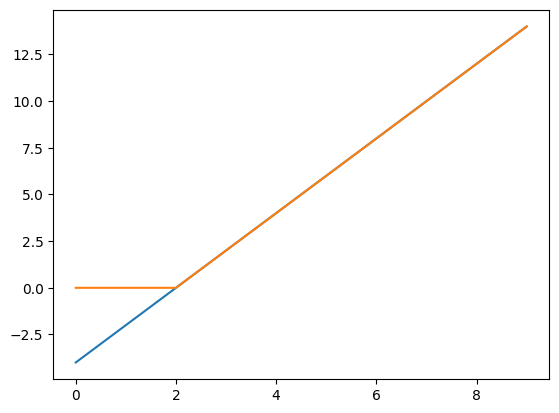

In [65]:
plt.plot(X, Y)
plt.plot(X,relu(Y))

In [66]:
def frand(y):
    return y + y*np.random.uniform(-0.1, 0.1, y.shape).astype('f')

In [67]:
Yr = frand(Y)

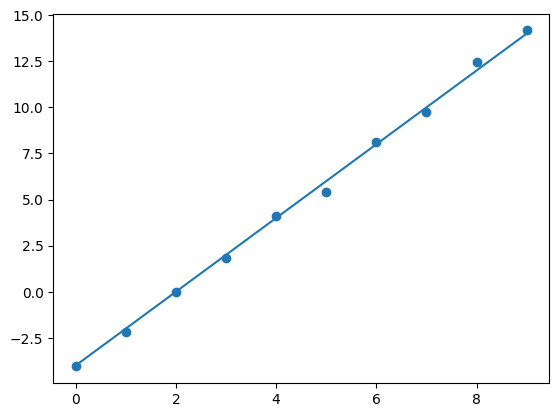

In [68]:
plt.plot(X, Y)
plt.scatter(X,Yr)

In [74]:
mse_grad_loop(Y,Yr)

tensor([ 0.0115,  0.0324, -0.0000,  0.0332, -0.0237,  0.1145, -0.0211,  0.0539,
        -0.0907, -0.0340])

In [86]:
torch.diagonal(mse_grad(Y,Yr))

tensor([[ 0.0115,  0.0324, -0.0000,  0.0332, -0.0237,  0.1145, -0.0211,  0.0539,
         -0.0907, -0.0340]])

In [136]:
query = nn.Linear(X.shape[0],4,bias=False)

In [137]:
query(X.squeeze(-1))

tensor([-0.7912,  3.8903, -0.1432,  2.1805], grad_fn=<SqueezeBackward4>)

In [138]:
query.weight

Parameter containing:
tensor([[ 0.0467,  0.0246, -0.2014,  0.3081, -0.2945, -0.0633,  0.0134, -0.2222,
          0.2712, -0.0597],
        [ 0.1748,  0.1808,  0.2427, -0.0732,  0.0135,  0.0656, -0.0198,  0.1542,
          0.1213,  0.1256],
        [ 0.1113, -0.1319,  0.0918, -0.1895, -0.0539, -0.1710, -0.2438,  0.0841,
          0.1486,  0.1255],
        [-0.2117, -0.2350, -0.0261,  0.0985,  0.2971, -0.1494, -0.2038,  0.0181,
          0.2380,  0.1026]], requires_grad=True)